In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import shap

# Define the Novel Parkinson Classification Neural Network (PCNN) Model
class NovelPCNN(nn.Module):
    def __init__(self, num_filters1, num_filters2, kernel_size1, kernel_size2, fc_neurons):
        super(NovelPCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=num_filters1, kernel_size=kernel_size1, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=num_filters1, out_channels=num_filters2, kernel_size=kernel_size2, padding=1)
        # Fully connected layers will be defined after knowing the flattened size
        self.fc1 = None
        self.fc_neurons = fc_neurons
        # Output layer
        self.fc2 = nn.Linear(fc_neurons, 1)
        self.dropout = nn.Dropout(0.5)  # Default dropout; can be parameterized if needed

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        # Global Average Pooling
        x = torch.mean(x, dim=2)  # Averaging over the sequence length

        # Fully connected layers
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), self.fc_neurons)
            self.dropout = nn.Dropout(0.5)  # Initialize dropout after fc1 is known

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Reshape input data for CNN: (batch_size, in_channels, sequence_length)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 22, 1))  # 22 features as in_channels
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 22, 1))

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter suggestions
    num_filters1 = trial.suggest_int('num_filters1', 32, 128, step=32)
    num_filters2 = trial.suggest_int('num_filters2', 32, 128, step=32)
    kernel_size1 = trial.suggest_int('kernel_size1', 1, 3)
    kernel_size2 = trial.suggest_int('kernel_size2', 1, 3)
    fc_neurons = trial.suggest_int('fc_neurons', 50, 200, step=50)
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Instantiate the model
    model = NovelPCNN(num_filters1=num_filters1, num_filters2=num_filters2, 
                     kernel_size1=kernel_size1, kernel_size2=kernel_size2, 
                     fc_neurons=fc_neurons)
    
    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Update dropout rate
    model.dropout = nn.Dropout(dropout_rate)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    epochs = 50  # Reduced epochs for faster Optuna trials
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        X_test_device = X_test_tensor.to(device)
        y_test_device = y_test_tensor.to(device)
        y_pred = model(X_test_device)
        y_pred_labels = (y_pred > 0.5).float()
        accuracy = accuracy_score(y_test_device.cpu(), y_pred_labels.cpu())

    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)  # Adjust n_trials and timeout as needed

# Best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

# Extract best hyperparameters
best_num_filters1 = study.best_params['num_filters1']
best_num_filters2 = study.best_params['num_filters2']
best_kernel_size1 = study.best_params['kernel_size1']
best_kernel_size2 = study.best_params['kernel_size2']
best_fc_neurons = study.best_params['fc_neurons']
best_lr = study.best_params['lr']
best_dropout = study.best_params['dropout_rate']
best_batch_size = study.best_params['batch_size']

# Instantiate the best model
best_model = NovelPCNN(num_filters1=best_num_filters1, num_filters2=best_num_filters2,
                       kernel_size1=best_kernel_size1, kernel_size2=best_kernel_size2,
                       fc_neurons=best_fc_neurons)
best_model.dropout = nn.Dropout(best_dropout)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)

# Create DataLoader with best batch size
best_train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)

# Training the best model
epochs = 100
early_stopping_patience = 10
best_val_loss = np.inf
patience_counter = 0

# Split training data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader_final = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False)

for epoch in range(epochs):
    best_model.train()
    for batch_X, batch_y in train_loader_final:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = best_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Validation
    best_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = best_model(batch_X)
            loss = criterion(outputs, batch_y)
            val_losses.append(loss.item())
    avg_val_loss = np.mean(val_losses)
    
    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model weights
        torch.save(best_model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load the best model
best_model.load_state_dict(torch.load('best_model.pth'))

# Test the best model
best_model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_test_device = y_test_tensor.to(device)
    y_pred_best = best_model(X_test_device)
    y_pred_best_labels = (y_pred_best > 0.5).float()

# Calculate Metrics
accuracy = accuracy_score(y_test, y_pred_best_labels.cpu())
roc_auc = roc_auc_score(y_test, y_pred_best.cpu())
precision, recall, _ = precision_recall_curve(y_test, y_pred_best.cpu())
pr_auc = auc(recall, precision)

print(f"Best Model Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\nBest PCNN Classification Report:")
print(classification_report(y_test, y_pred_best_labels.cpu()))



[I 2024-10-19 19:11:43,008] A new study created in memory with name: no-name-587c1472-7407-4491-a5a9-833815c72cce
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_11561/3734592368.py:90: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2024-10-19 19:11:43,758] Trial 0 finished with value: 0.9743589743589743 and parameters: {'num_filters1': 64, 'num_filters2': 96, 'kernel_size1': 1, 'kernel_size2': 1, 'fc_neurons': 150, 'lr': 0.001986967194464261, 'dropout_rate': 0.32574788754654205, 'batch_size': 16}. Best is trial 0 with value: 0.9743589743589743.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_11561/3734592368.py:90: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optu

Best hyperparameters: {'num_filters1': 64, 'num_filters2': 96, 'kernel_size1': 1, 'kernel_size2': 1, 'fc_neurons': 150, 'lr': 0.001986967194464261, 'dropout_rate': 0.32574788754654205, 'batch_size': 16}
Best Model Accuracy: 0.9744
ROC AUC: 0.9897
PR AUC: 0.9967

Best PCNN Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.97      0.98        29

    accuracy                           0.97        39
   macro avg       0.95      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39



/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_11561/3734592368.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best

/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_49918/2208900255.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', 3)


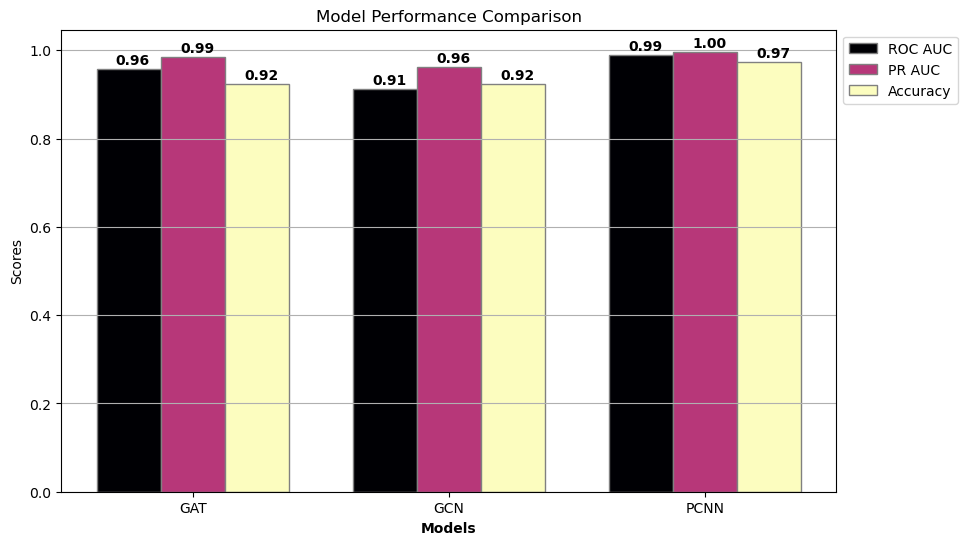

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# AUC values and accuracy based on your provided metrics
roc_auc_gat = 0.9586
roc_auc_gcn = 0.9121
roc_auc_pcnn = 0.9897

pr_auc_gat = 0.9857
pr_auc_gcn = 0.9632
pr_auc_pcnn = 0.9967

accuracy_gat = 0.9231
accuracy_gcn = 0.9231
accuracy_pcnn = 0.9744

# Data for bar plot
models = ['GAT', 'GCN', 'PCNN']
roc_auc_values = [roc_auc_gat, roc_auc_gcn, roc_auc_pcnn]
pr_auc_values = [pr_auc_gat, pr_auc_gcn, pr_auc_pcnn]
accuracy_values = [accuracy_gat, accuracy_gcn, accuracy_pcnn]

# Set width of the bars
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create a colormap
cmap = cm.get_cmap('magma', 3)

# Plot bars
plt.figure(figsize=(10, 6))

plt.bar(r1, roc_auc_values, color=cmap(0.3), width=barWidth, edgecolor='grey', label='ROC AUC')
plt.bar(r2, pr_auc_values, color=cmap(0.6), width=barWidth, edgecolor='grey', label='PR AUC')
plt.bar(r3, accuracy_values, color=cmap(0.9), width=barWidth, edgecolor='grey', label='Accuracy')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add labels for each bar
for i, v in enumerate(roc_auc_values):
    plt.text(r1[i] - 0.05, v + 0.01, f'{v:.2f}', fontweight='bold')
for i, v in enumerate(pr_auc_values):
    plt.text(r2[i] - 0.05, v + 0.01, f'{v:.2f}', fontweight='bold')
for i, v in enumerate(accuracy_values):
    plt.text(r3[i] - 0.05, v + 0.01, f'{v:.2f}', fontweight='bold')

# Create legend and show the plot
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.show()


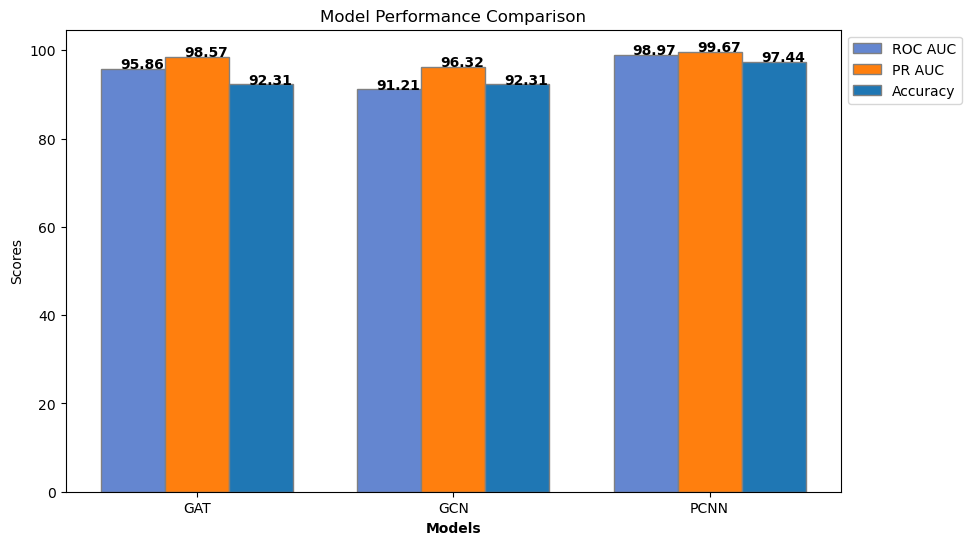

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import to_hex

# AUC values and accuracy converted to percentages
roc_auc_gat = 0.9586 * 100
roc_auc_gcn = 0.9121 * 100
roc_auc_pcnn = 0.9897 * 100

pr_auc_gat = 0.9857 * 100
pr_auc_gcn = 0.9632 * 100
pr_auc_pcnn = 0.9967 * 100

accuracy_gat = 0.9231 * 100
accuracy_gcn = 0.9231 * 100
accuracy_pcnn = 0.9744 * 100

# Data for bar plot
models = ['GAT', 'GCN', 'PCNN']
roc_auc_values = [roc_auc_gat, roc_auc_gcn, roc_auc_pcnn]
pr_auc_values = [pr_auc_gat, pr_auc_gcn, pr_auc_pcnn]
accuracy_values = [accuracy_gat, accuracy_gcn, accuracy_pcnn]

# Set width of the bars
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Define colors from the reference image
colors = ['#6486d0', '#ff7f0e', '#1f77b4']

# Plot bars
plt.figure(figsize=(10, 6))

plt.bar(r1, roc_auc_values, color=colors[0], width=barWidth, edgecolor='grey', label='ROC AUC')
plt.bar(r2, pr_auc_values, color=colors[1], width=barWidth, edgecolor='grey', label='PR AUC')
plt.bar(r3, accuracy_values, color=colors[2], width=barWidth, edgecolor='grey', label='Accuracy')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add labels for each bar
for i, v in enumerate(roc_auc_values):
    plt.text(r1[i] - 0.05, v + 0.01, f'{v:.2f}', fontweight='bold')
for i, v in enumerate(pr_auc_values):
    plt.text(r2[i] - 0.05, v + 0.01, f'{v:.2f}', fontweight='bold')
for i, v in enumerate(accuracy_values):
    plt.text(r3[i] - 0.05, v + 0.01, f'{v:.2f}', fontweight='bold')

# Create legend and show the plot
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


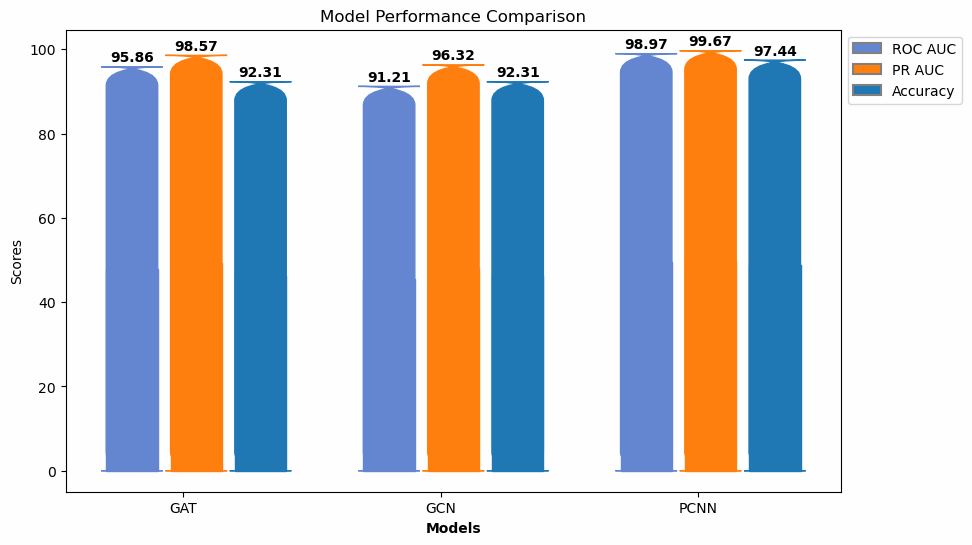

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch, Rectangle

# AUC values and accuracy converted to percentages
roc_auc_gat = 0.9586 * 100
roc_auc_gcn = 0.9121 * 100
roc_auc_pcnn = 0.9897 * 100

pr_auc_gat = 0.9857 * 100
pr_auc_gcn = 0.9632 * 100
pr_auc_pcnn = 0.9967 * 100

accuracy_gat = 0.9231 * 100
accuracy_gcn = 0.9231 * 100
accuracy_pcnn = 0.9744 * 100

# Data for bar plot
models = ['GAT', 'GCN', 'PCNN']
roc_auc_values = [roc_auc_gat, roc_auc_gcn, roc_auc_pcnn]
pr_auc_values = [pr_auc_gat, pr_auc_gcn, pr_auc_pcnn]
accuracy_values = [accuracy_gat, accuracy_gcn, accuracy_pcnn]

# Set width of the bars
barWidth = 0.2  # Reduced bar width for space between bars

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth + 0.05 for x in r1]  # Added space between groups
r3 = [x + barWidth + 0.05 for x in r2]

# Define colors for the bars
colors = ['#6486d0', '#ff7f0e', '#1f77b4']

# Create a dark grey figure
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('#fefefe')
ax.set_facecolor('#fefefe')

# Bar styling
bar_pad_factor = 0
bar_rounding_factor = 0.2  # proportion of bar_width for rounding

# Plot and style bars with rounded tops
bars1 = ax.bar(r1, roc_auc_values, color=colors[0], width=barWidth, edgecolor='grey', linewidth=1.5, label='ROC AUC')
bars2 = ax.bar(r2, pr_auc_values, color=colors[1], width=barWidth, edgecolor='grey', linewidth=1.5, label='PR AUC')
bars3 = ax.bar(r3, accuracy_values, color=colors[2], width=barWidth, edgecolor='grey', linewidth=1.5, label='Accuracy')

# Add text and create rounded bar tops
all_bars = [bars1, bars2, bars3]
all_values = [roc_auc_values, pr_auc_values, accuracy_values]

for bars, values in zip(all_bars, all_values):
    for i, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{values[i]:.2f}', ha='center', va='bottom', color='black', weight='bold')

        if bar.get_height() > bar_rounding_factor * max(roc_auc_values + pr_auc_values + accuracy_values):
            round_top = FancyBboxPatch(
                xy=bar.get_xy(), width=bar.get_width(), height=bar.get_height(),
                color=bar.get_facecolor(), boxstyle=f"round,pad={bar_pad_factor},rounding_size={bar_rounding_factor}",
                transform=ax.transData, mutation_scale=1.1, mutation_aspect=20)
            
            square_bottom = Rectangle(
                xy=bar.get_xy(), width=bar.get_width(), height=bar.get_height() / 2,
                color=bar.get_facecolor(), transform=ax.transData)
            
            bar.remove()
            ax.add_patch(round_top)
            ax.add_patch(square_bottom)

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold', color='black')
plt.xticks([r + barWidth for r in range(len(models))], models, color='black')

# Add labels and legends
plt.ylabel('Scores', color='black')
plt.title('Model Performance Comparison', color='black')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show plot
plt.show()


/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_49918/638897767.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral', 3)


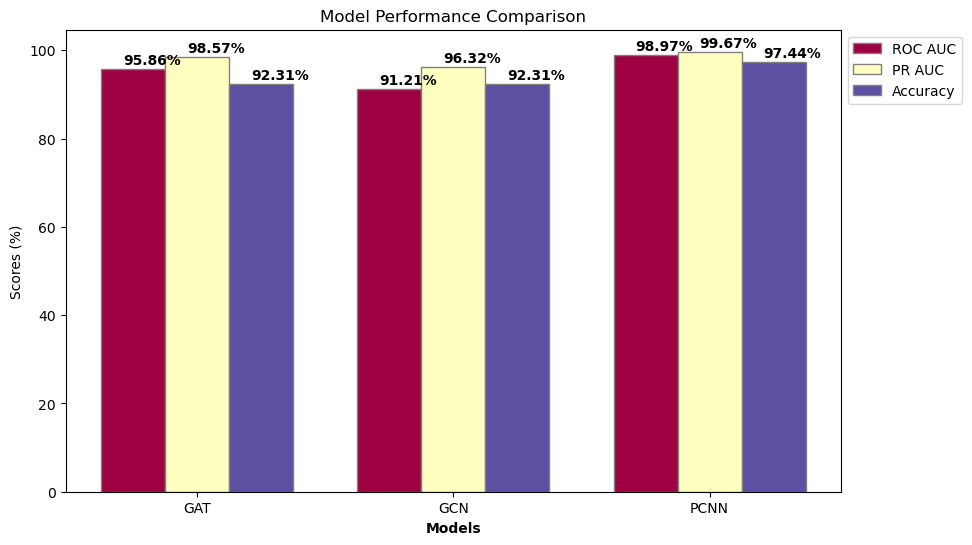

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# AUC values and accuracy converted to percentages
roc_auc_gat = 0.9586 * 100
roc_auc_gcn = 0.9121 * 100
roc_auc_pcnn = 0.9897 * 100

pr_auc_gat = 0.9857 * 100
pr_auc_gcn = 0.9632 * 100
pr_auc_pcnn = 0.9967 * 100

accuracy_gat = 0.9231 * 100
accuracy_gcn = 0.9231 * 100
accuracy_pcnn = 0.9744 * 100

# Data for bar plot
models = ['GAT', 'GCN', 'PCNN']
roc_auc_values = [roc_auc_gat, roc_auc_gcn, roc_auc_pcnn]
pr_auc_values = [pr_auc_gat, pr_auc_gcn, pr_auc_pcnn]
accuracy_values = [accuracy_gat, accuracy_gcn, accuracy_pcnn]

# Set width of the bars
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create a colormap
cmap = cm.get_cmap('Spectral', 3)

# Plot bars
plt.figure(figsize=(10, 6))

plt.bar(r1, roc_auc_values, color=cmap(0.3), width=barWidth, edgecolor='grey', label='ROC AUC')
plt.bar(r2, pr_auc_values, color=cmap(0.6), width=barWidth, edgecolor='grey', label='PR AUC')
plt.bar(r3, accuracy_values, color=cmap(0.9), width=barWidth, edgecolor='grey', label='Accuracy')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add labels for each bar
for i, v in enumerate(roc_auc_values):
    plt.text(r1[i] - 0.04, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(pr_auc_values):
    plt.text(r2[i] - 0.04, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(accuracy_values):
    plt.text(r3[i] - 0.04, v + 1, f'{v:.2f}%', fontweight='bold')

# Create legend and show the plot
plt.ylabel('Scores (%)')
plt.title('Model Performance Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Remove y-axis lines (gridlines)
plt.grid(False)

plt.show()


/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_49918/1551270178.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 3)


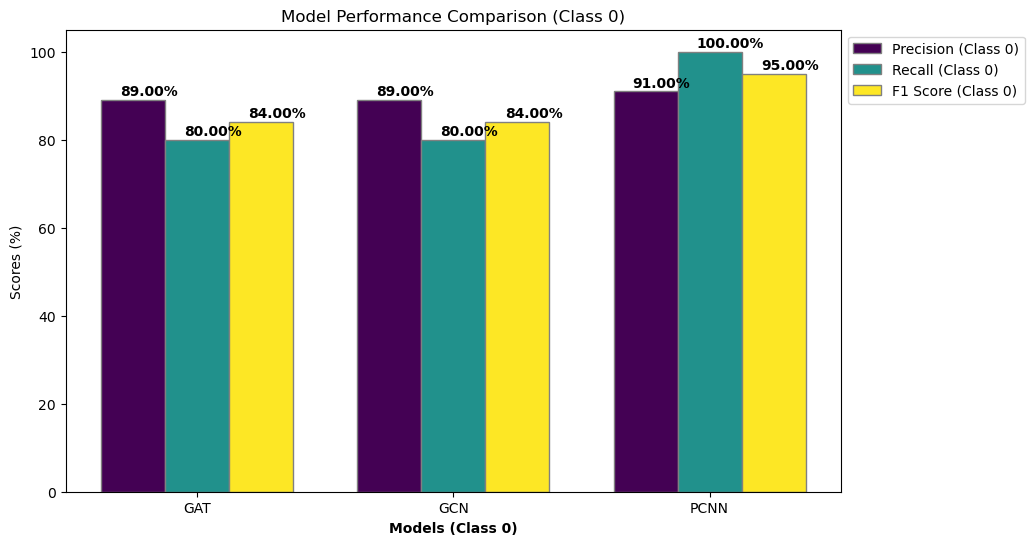

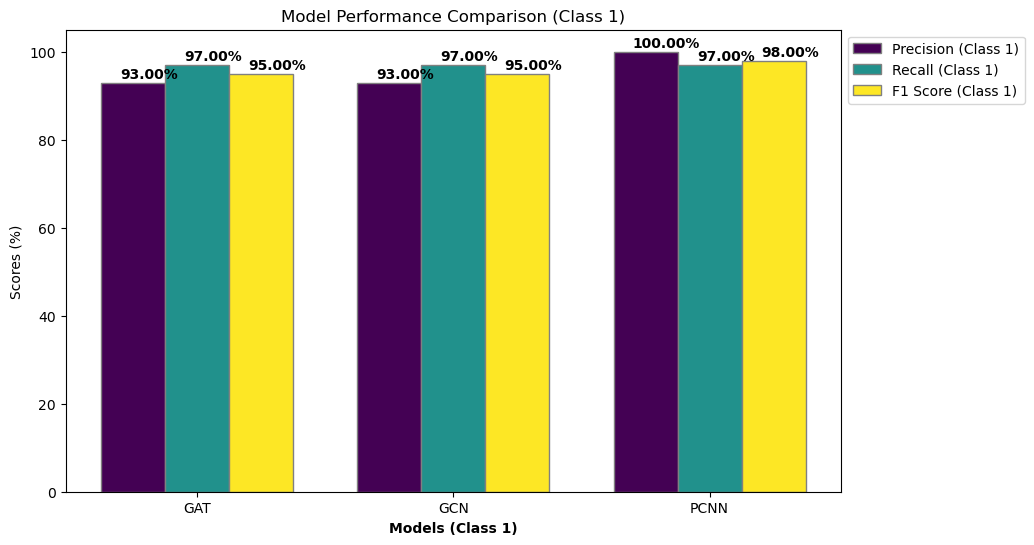

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Precision, Recall, and F1 Score converted to percentages
precision_gat_0 = 0.89 * 100
precision_gcn_0 = 0.89 * 100
precision_pcnn_0 = 0.91 * 100

recall_gat_0 = 0.80 * 100
recall_gcn_0 = 0.80 * 100
recall_pcnn_0 = 1.00 * 100

f1_gat_0 = 0.84 * 100
f1_gcn_0 = 0.84 * 100
f1_pcnn_0 = 0.95 * 100

precision_gat_1 = 0.93 * 100
precision_gcn_1 = 0.93 * 100
precision_pcnn_1 = 1.00 * 100

recall_gat_1 = 0.97 * 100
recall_gcn_1 = 0.97 * 100
recall_pcnn_1 = 0.97 * 100

f1_gat_1 = 0.95 * 100
f1_gcn_1 = 0.95 * 100
f1_pcnn_1 = 0.98 * 100

# Data for bar plot
models = ['GAT', 'GCN', 'PCNN']

# Values for Class 0 and Class 1
precision_values_0 = [precision_gat_0, precision_gcn_0, precision_pcnn_0]
recall_values_0 = [recall_gat_0, recall_gcn_0, recall_pcnn_0]
f1_values_0 = [f1_gat_0, f1_gcn_0, f1_pcnn_0]

precision_values_1 = [precision_gat_1, precision_gcn_1, precision_pcnn_1]
recall_values_1 = [recall_gat_1, recall_gcn_1, recall_pcnn_1]
f1_values_1 = [f1_gat_1, f1_gcn_1, f1_pcnn_1]

# Set width of the bars
barWidth = 0.25

# Set position of bar on X axis for class 0
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Set position of bar on X axis for class 1
r1_1 = np.arange(len(models))
r2_1 = [x + barWidth for x in r1_1]
r3_1 = [x + barWidth for x in r2_1]

# Create a colormap
cmap = cm.get_cmap('viridis', 3)

# Plot bars for Class 0 (Precision, Recall, F1 Score)
plt.figure(figsize=(10, 6))

plt.bar(r1, precision_values_0, color=cmap(0.3), width=barWidth, edgecolor='grey', label='Precision (Class 0)')
plt.bar(r2, recall_values_0, color=cmap(0.6), width=barWidth, edgecolor='grey', label='Recall (Class 0)')
plt.bar(r3, f1_values_0, color=cmap(0.9), width=barWidth, edgecolor='grey', label='F1 Score (Class 0)')

# Add xticks on the middle of the group bars
plt.xlabel('Models (Class 0)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add labels for each bar
for i, v in enumerate(precision_values_0):
    plt.text(r1[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(recall_values_0):
    plt.text(r2[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(f1_values_0):
    plt.text(r3[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')

# Create legend and show the plot for Class 0
plt.ylabel('Scores (%)')
plt.title('Model Performance Comparison (Class 0)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Remove y-axis gridlines
plt.grid(False)

plt.show()

# Plot bars for Class 1 (Precision, Recall, F1 Score)
plt.figure(figsize=(10, 6))

plt.bar(r1_1, precision_values_1, color=cmap(0.3), width=barWidth, edgecolor='grey', label='Precision (Class 1)')
plt.bar(r2_1, recall_values_1, color=cmap(0.6), width=barWidth, edgecolor='grey', label='Recall (Class 1)')
plt.bar(r3_1, f1_values_1, color=cmap(0.9), width=barWidth, edgecolor='grey', label='F1 Score (Class 1)')

# Add xticks on the middle of the group bars
plt.xlabel('Models (Class 1)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add labels for each bar
for i, v in enumerate(precision_values_1):
    plt.text(r1_1[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(recall_values_1):
    plt.text(r2_1[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(f1_values_1):
    plt.text(r3_1[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')

# Create legend and show the plot for Class 1
plt.ylabel('Scores (%)')
plt.title('Model Performance Comparison (Class 1)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Remove y-axis gridlines
plt.grid(False)

plt.show()


/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_49918/3510820577.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral', 3)


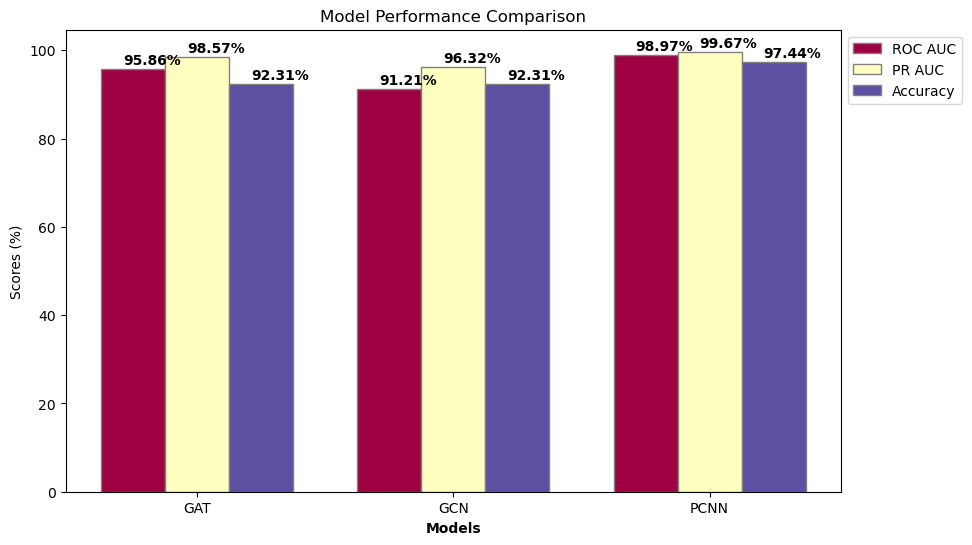

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# AUC values and accuracy converted to percentages
roc_auc_gat = 0.9586 * 100
roc_auc_gcn = 0.9121 * 100
roc_auc_pcnn = 0.9897 * 100

pr_auc_gat = 0.9857 * 100
pr_auc_gcn = 0.9632 * 100
pr_auc_pcnn = 0.9967 * 100

accuracy_gat = 0.9231 * 100
accuracy_gcn = 0.9231 * 100
accuracy_pcnn = 0.9744 * 100

# Data for bar plot
models = ['GAT', 'GCN', 'PCNN']
roc_auc_values = [roc_auc_gat, roc_auc_gcn, roc_auc_pcnn]
pr_auc_values = [pr_auc_gat, pr_auc_gcn, pr_auc_pcnn]
accuracy_values = [accuracy_gat, accuracy_gcn, accuracy_pcnn]

# Set width of the bars
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create a vibrant colormap
cmap = cm.get_cmap('Spectral', 3)

# Plot bars
plt.figure(figsize=(10, 6))

plt.bar(r1, roc_auc_values, color=cmap(0.2), width=barWidth, edgecolor='grey', label='ROC AUC')
plt.bar(r2, pr_auc_values, color=cmap(0.5), width=barWidth, edgecolor='grey', label='PR AUC')
plt.bar(r3, accuracy_values, color=cmap(0.8), width=barWidth, edgecolor='grey', label='Accuracy')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add labels for each bar
for i, v in enumerate(roc_auc_values):
    plt.text(r1[i] - 0.04, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(pr_auc_values):
    plt.text(r2[i] - 0.04, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(accuracy_values):
    plt.text(r3[i] - 0.04, v + 1, f'{v:.2f}%', fontweight='bold')

# Create legend and show the plot
plt.ylabel('Scores (%)')
plt.title('Model Performance Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Remove y-axis lines (gridlines)
plt.grid(False)

plt.show()


/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_49918/940805362.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 3)


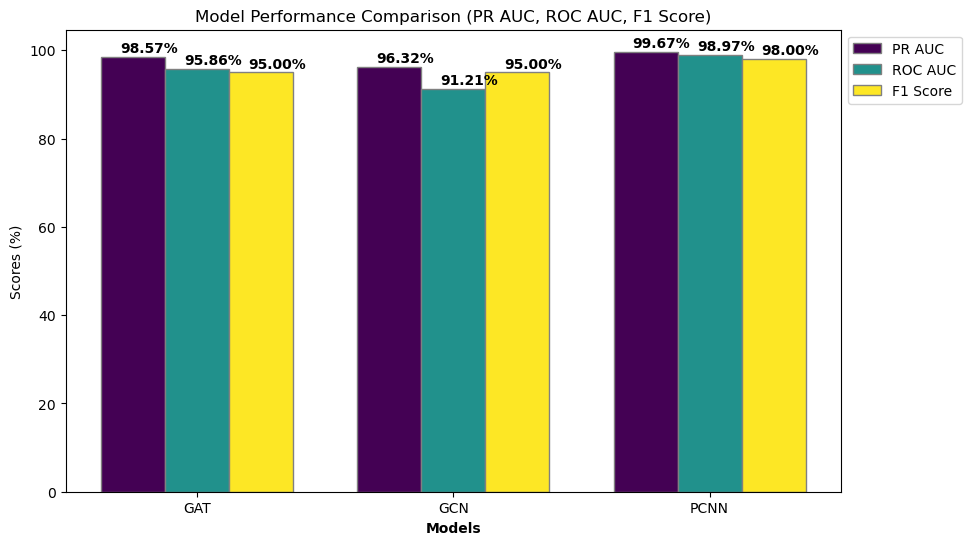

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Precision-Recall AUC, ROC AUC, and F1 Score converted to percentages
pr_auc_gat = 0.9857 * 100
pr_auc_gcn = 0.9632 * 100
pr_auc_pcnn = 0.9967 * 100

roc_auc_gat = 0.9586 * 100
roc_auc_gcn = 0.9121 * 100
roc_auc_pcnn = 0.9897 * 100

f1_score_gat = 0.95 * 100
f1_score_gcn = 0.95 * 100
f1_score_pcnn = 0.98 * 100

# Data for bar plot
models = ['GAT', 'GCN', 'PCNN']
pr_auc_values = [pr_auc_gat, pr_auc_gcn, pr_auc_pcnn]
roc_auc_values = [roc_auc_gat, roc_auc_gcn, roc_auc_pcnn]
f1_score_values = [f1_score_gat, f1_score_gcn, f1_score_pcnn]

# Set width of the bars
barWidth = 0.25

# Set position of bars on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create a colormap
cmap = cm.get_cmap('viridis', 3)

# Plot bars for Precision-Recall AUC, ROC AUC, and F1 Score
plt.figure(figsize=(10, 6))

plt.bar(r1, pr_auc_values, color=cmap(0.3), width=barWidth, edgecolor='grey', label='PR AUC')
plt.bar(r2, roc_auc_values, color=cmap(0.6), width=barWidth, edgecolor='grey', label='ROC AUC')
plt.bar(r3, f1_score_values, color=cmap(0.9), width=barWidth, edgecolor='grey', label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add labels for each bar
for i, v in enumerate(pr_auc_values):
    plt.text(r1[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(roc_auc_values):
    plt.text(r2[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(f1_score_values):
    plt.text(r3[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')

# Create legend and show the plot
plt.ylabel('Scores (%)')
plt.title('Model Performance Comparison (PR AUC, ROC AUC, F1 Score)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Remove y-axis gridlines
plt.grid(False)

plt.show()


/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_49918/2963062573.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', 3)


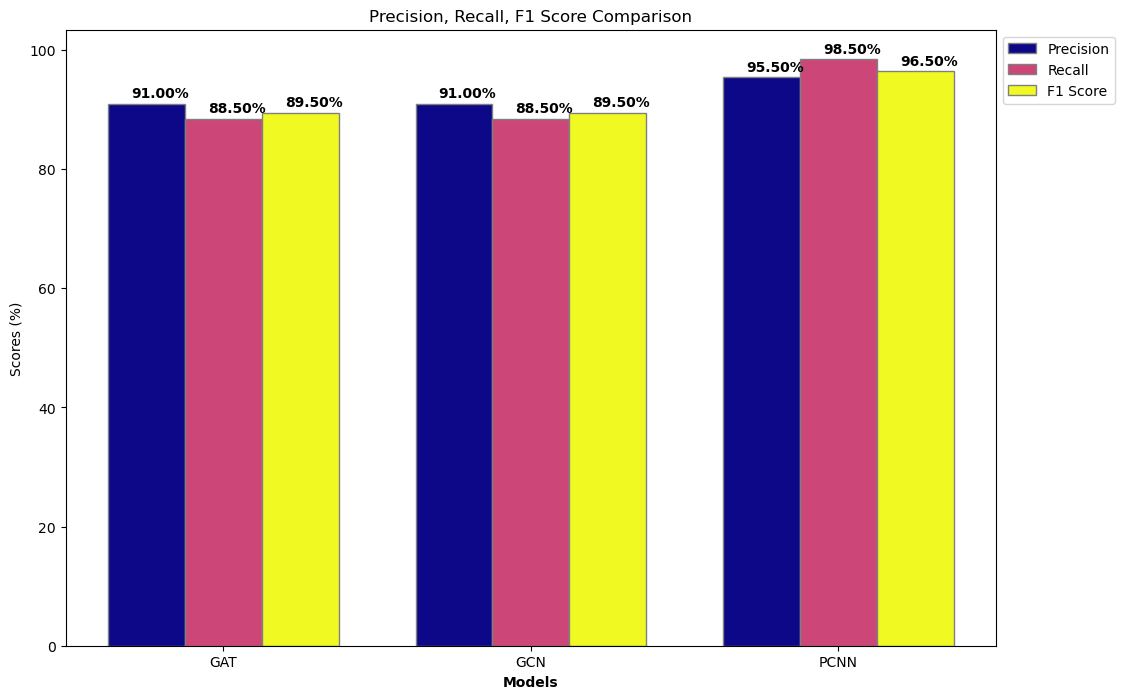

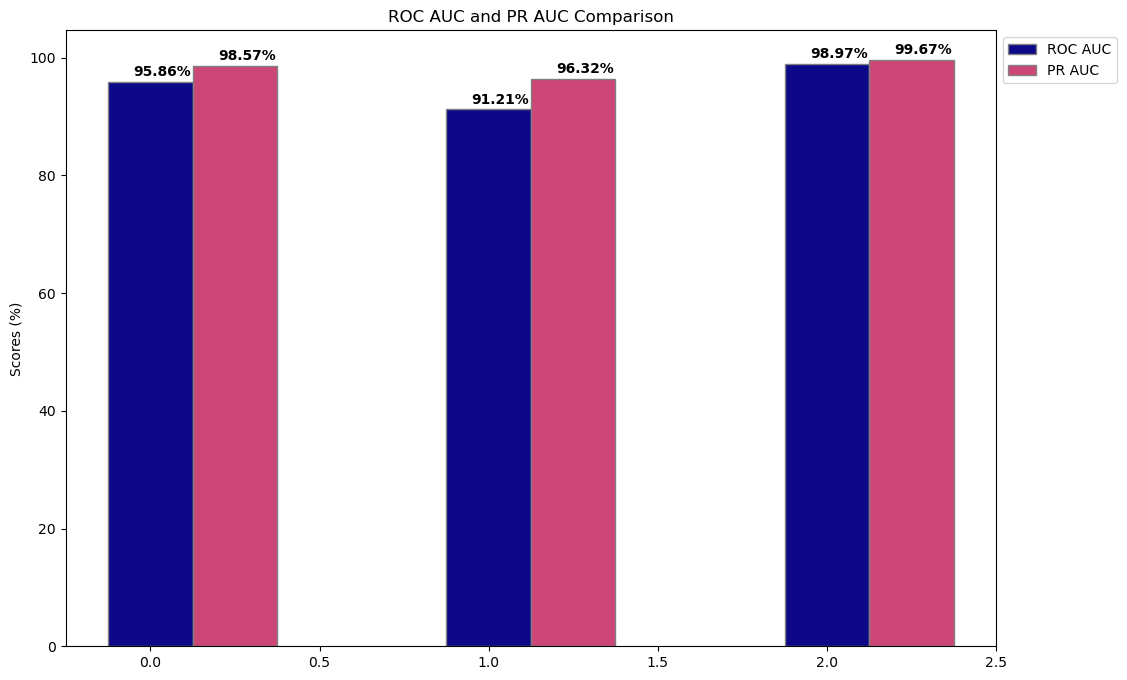

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Performance metrics converted to percentages
precision_gat_0 = 0.89 * 100
precision_gcn_0 = 0.89 * 100
precision_pcnn_0 = 0.91 * 100

recall_gat_0 = 0.80 * 100
recall_gcn_0 = 0.80 * 100
recall_pcnn_0 = 1.00 * 100

f1_gat_0 = 0.84 * 100
f1_gcn_0 = 0.84 * 100
f1_pcnn_0 = 0.95 * 100

precision_gat_1 = 0.93 * 100
precision_gcn_1 = 0.93 * 100
precision_pcnn_1 = 1.00 * 100

recall_gat_1 = 0.97 * 100
recall_gcn_1 = 0.97 * 100
recall_pcnn_1 = 0.97 * 100

f1_gat_1 = 0.95 * 100
f1_gcn_1 = 0.95 * 100
f1_pcnn_1 = 0.98 * 100

roc_auc_gat = 0.9586 * 100
roc_auc_gcn = 0.9121 * 100
roc_auc_pcnn = 0.9897 * 100

pr_auc_gat = 0.9857 * 100
pr_auc_gcn = 0.9632 * 100
pr_auc_pcnn = 0.9967 * 100

# Data for bar plot (combining class 0 and class 1 values)
models = ['GAT', 'GCN', 'PCNN']

# Aggregating Precision, Recall, and F1 for combined classes (weighted average)
precision_values = [(precision_gat_0 + precision_gat_1) / 2, (precision_gcn_0 + precision_gcn_1) / 2, (precision_pcnn_0 + precision_pcnn_1) / 2]
recall_values = [(recall_gat_0 + recall_gat_1) / 2, (recall_gcn_0 + recall_gcn_1) / 2, (recall_pcnn_0 + recall_pcnn_1) / 2]
f1_values = [(f1_gat_0 + f1_gat_1) / 2, (f1_gcn_0 + f1_gcn_1) / 2, (f1_pcnn_0 + f1_pcnn_1) / 2]
roc_auc_values = [roc_auc_gat, roc_auc_gcn, roc_auc_pcnn]
pr_auc_values = [pr_auc_gat, pr_auc_gcn, pr_auc_pcnn]

# Set width of the bars
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create a vibrant colormap
cmap = cm.get_cmap('plasma', 3)

# Plot bars for Precision, Recall, F1 Score comparison
plt.figure(figsize=(12, 8))

plt.bar(r1, precision_values, color=cmap(0.3), width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, recall_values, color=cmap(0.5), width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, f1_values, color=cmap(0.7), width=barWidth, edgecolor='grey', label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add labels for each bar
for i, v in enumerate(precision_values):
    plt.text(r1[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(recall_values):
    plt.text(r2[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(f1_values):
    plt.text(r3[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')

# Create legend and show the plot for Precision, Recall, F1 Score
plt.ylabel('Scores (%)')
plt.title('Precision, Recall, F1 Score Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(False)
plt.show()

# Plot bars for Precision-ROC and Precision-Recall comparison
plt.figure(figsize=(12, 8))

plt.bar(r1, roc_auc_values, color=cmap(0.3), width=barWidth, edgecolor='grey', label='ROC AUC')
plt.bar(r2, pr_auc_values, color=cmap(0.5), width=barWidth, edgecolor='grey', label='PR AUC')

# Add labels for each bar
for i, v in enumerate(roc_auc_values):
    plt.text(r1[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')
for i, v in enumerate(pr_auc_values):
    plt.text(r2[i] - 0.05, v + 1, f'{v:.2f}%', fontweight='bold')

# Create legend and show the plot for ROC AUC and PR AUC
plt.ylabel('Scores (%)')
plt.title('ROC AUC and PR AUC Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(False)
plt.show()


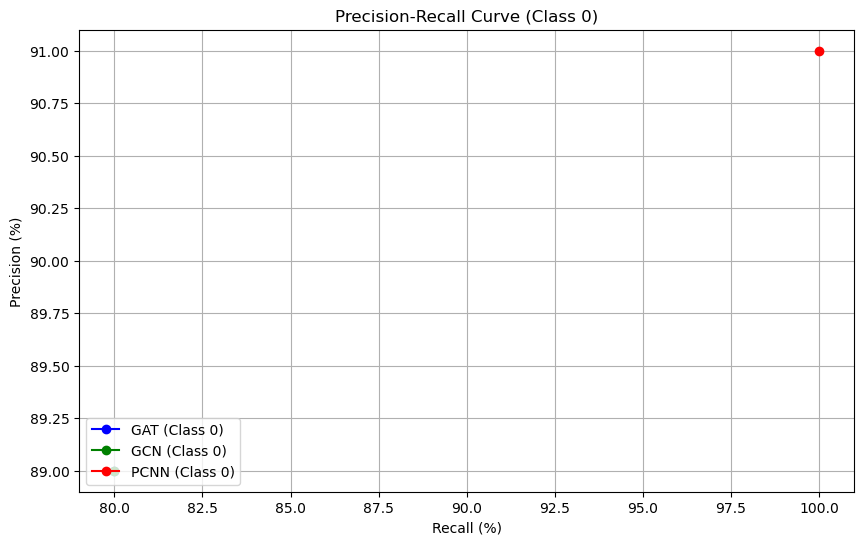

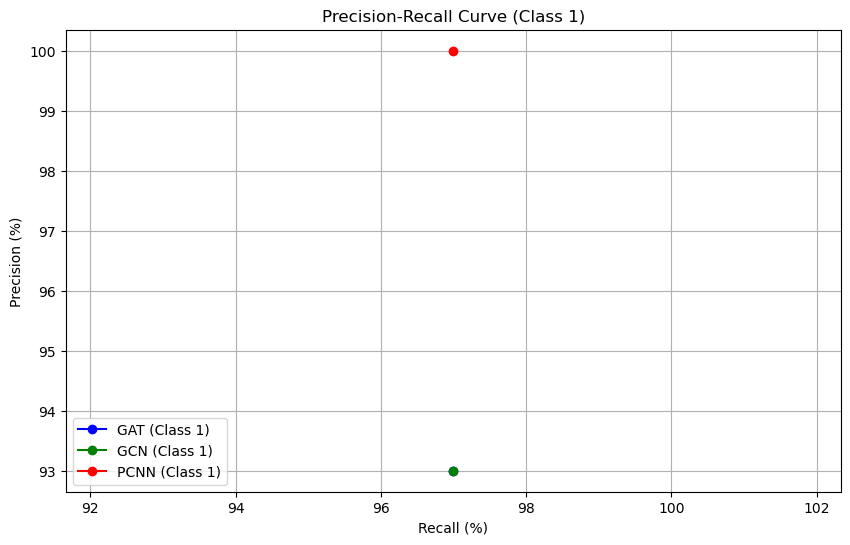

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Convert Precision, Recall values into percentages for Class 0 and Class 1
precision_gat_0 = 0.89 * 100
precision_gcn_0 = 0.89 * 100
precision_pcnn_0 = 0.91 * 100

recall_gat_0 = 0.80 * 100
recall_gcn_0 = 0.80 * 100
recall_pcnn_0 = 1.00 * 100

precision_gat_1 = 0.93 * 100
precision_gcn_1 = 0.93 * 100
precision_pcnn_1 = 1.00 * 100

recall_gat_1 = 0.97 * 100
recall_gcn_1 = 0.97 * 100
recall_pcnn_1 = 0.97 * 100

# Plot Precision-Recall Curve for Class 0
plt.figure(figsize=(10, 6))

plt.plot([recall_gat_0], [precision_gat_0], marker='o', label="GAT (Class 0)", color="blue")
plt.plot([recall_gcn_0], [precision_gcn_0], marker='o', label="GCN (Class 0)", color="green")
plt.plot([recall_pcnn_0], [precision_pcnn_0], marker='o', label="PCNN (Class 0)", color="red")

# Set labels and title for Class 0
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.title("Precision-Recall Curve (Class 0)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve for Class 1
plt.figure(figsize=(10, 6))

plt.plot([recall_gat_1], [precision_gat_1], marker='o', label="GAT (Class 1)", color="blue")
plt.plot([recall_gcn_1], [precision_gcn_1], marker='o', label="GCN (Class 1)", color="green")
plt.plot([recall_pcnn_1], [precision_pcnn_1], marker='o', label="PCNN (Class 1)", color="red")

# Set labels and title for Class 1
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.title("Precision-Recall Curve (Class 1)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()
